In [1]:
import importlib, numba, os, sys, time, pickle, resource, copy, glob
import numpy as np, scipy.ndimage as ndimage, astropy.units as u, matplotlib.pyplot as plt

from sys import path
from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord

base_path = '../pydrad' #os.getcwd()
path.append(os.path.join(base_path))
path.append(os.path.join(base_path,'modules'))

from aia_tresp import aia_temperature_response
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures bigger
plt.rcParams.update({'figure.figsize':[17,8]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=160)

In [2]:
import pathlib
import tempfile

import astropy.units as u
from astropy.visualization import ImageNormalize, LogStretch

from pydrad.configure import Configure
from pydrad.configure.data import get_defaults
from pydrad.configure.util import get_clean_hydrad, run_shell_command
from pydrad.parse import Strand

hydrad_dir = '../files/hydrad_runs' # pathlib.Path(tempfile.mkdtemp())  # Change to wherever you want to save your clean HYDRAD copy

In [3]:
hydrad_clean = os.path.join(hydrad_dir,'hydrad-clean')
if not os.path.exists(hydrad_clean):
        get_clean_hydrad(hydrad_clean, from_github=True)

In [4]:
ebtel_config_path = '../files/runs/heat_config_runs_h0.6_g0.0/hydro_config/*.xml'
ebtel_xml_files = sorted(glob.glob(ebtel_config_path))

In [5]:
from util import parse_xml_config

mags = []
loop_lengths = []
filenames = []

for loop_config in ebtel_xml_files: 
    config_data = parse_xml_config(loop_config)
    try: 
        mags.append(float(config_data['heating']['events'][100]['magnitude'].split()[0]))
        loop_lengths.append(config_data['loop_length'])
        filenames.append(loop_config)
    except (KeyError, IndexError) as e:
        #print(f"Error processing {loop_config}: {e}")
        continue  # Skip this iteration and continue with the next file

mags = np.array(mags)
loop_lengths = np.array(loop_lengths)
filenames = np.array(filenames) 


In [6]:
m_thresh = 4.5e-5; l_thresh = 50e7
large_loops = loop_lengths[(mags>m_thresh) & (loop_lengths>l_thresh) ]
large_mags = mags[(mags>m_thresh) & (loop_lengths>l_thresh) ]
large_files = filenames[(mags>m_thresh) & (loop_lengths>l_thresh) ]
print(len(large_files))

394


Mean Loop Length: 21.70531407043147
Mean heating mag: 7.804555462283043e-05


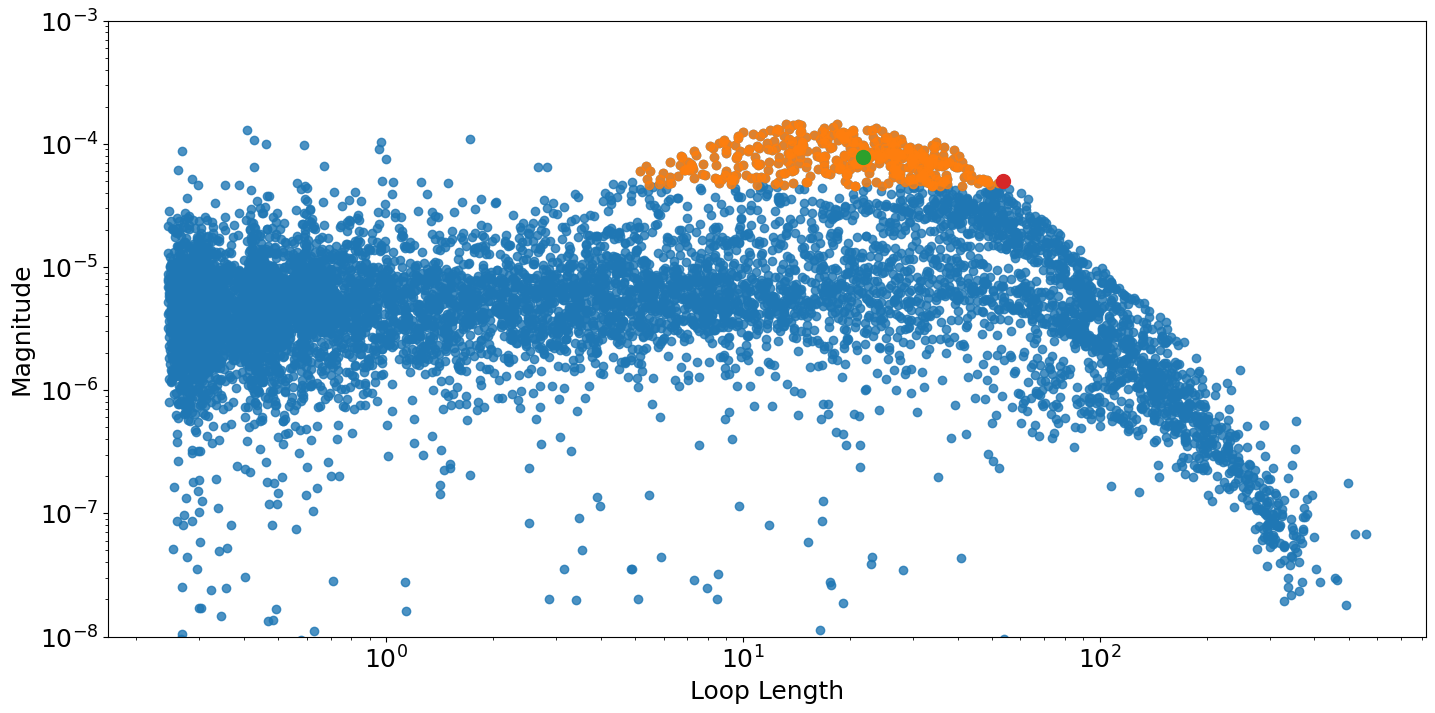

In [7]:
Mags = []
Loop_lengths = []

for loop_config in large_files: 
    config_data = parse_xml_config(loop_config)
    try: 
        Mags.append(float(config_data['heating']['events'][100]['magnitude'].split()[0]))
        Loop_lengths.append(config_data['loop_length'])
    except (KeyError, IndexError) as e:
        #print(f"Error processing {loop_config}: {e}")
        continue  # Skip this iteration and continue with the next file

Mags = np.array(Mags)
Loop_lengths = np.array(Loop_lengths)

plt.scatter(loop_lengths*1e-8, mags,alpha=0.8)
plt.scatter(Loop_lengths*1e-8, Mags,alpha=0.8)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Loop Length')
plt.ylabel('Magnitude')
plt.ylim(1e-8,1e-3)

ll = np.mean(Loop_lengths)
hm = np.mean(Mags)

print(f'Mean Loop Length: {ll*1e-8}')
print(f'Mean heating mag: {hm}')

plt.scatter(ll*1e-8,hm,s=100)

imax = np.argmax(Loop_lengths)
plt.scatter(Loop_lengths[imax]*1e-8,Mags[imax],s=100)

In [7]:
loopfile=large_files[imax]
print(loopfile)

NameError: name 'imax' is not defined

In [14]:
config_data = parse_xml_config(loopfile)
loop_length = (config_data['loop_length']*u.cm).to(u.Mm)
print(loop_length)

53.544093806250004 Mm


In [15]:
location = 0.5
scale_height = 0.25

In [16]:
from util import get_events

In [17]:
events = get_events(config_data['heating'],loop_length,location,scale_height)

In [18]:
events[0]

{'time_start': <Quantity 33.00858716 s>,
 'rise_duration': <Quantity 100. s>,
 'decay_duration': <Quantity 100. s>,
 'total_duration': <Quantity 200. s>,
 'location': <Quantity 26.7720469 Mm>,
 'scale_height': <Quantity 13.38602345 Mm>,
 'rate': <Quantity 7.90207155e-05 erg / (s cm3)>}

In [19]:
e2 = events[0:500]
(e2[-1]['time_start']+e2[-1]['total_duration']).value

np.float64(12707.436735471741)

### consistency check for Gaussian heating conservation:

In [20]:
vol_heat=float(config_data['heating']['events'][500]['magnitude'].split()[0])
print(vol_heat)

ll = config_data['loop_length']
print(ll/1e8)

4.951888995512833e-05
53.54409380625


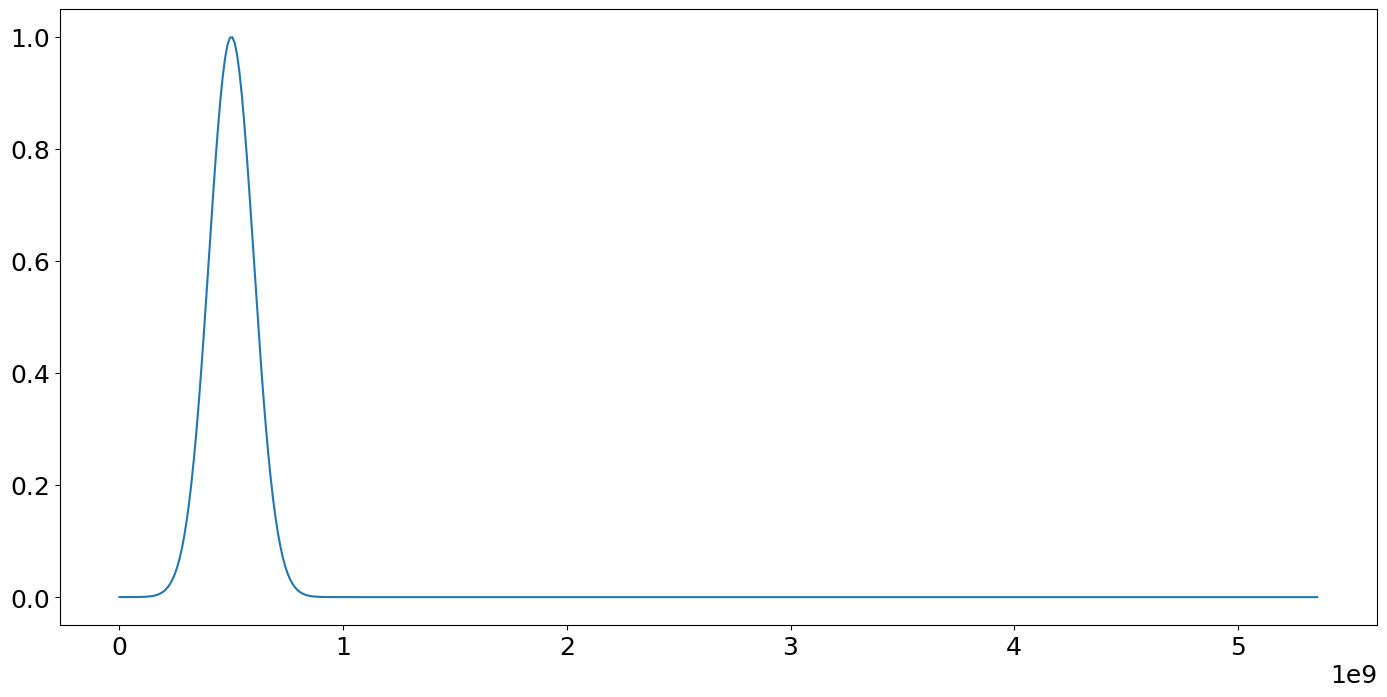

In [21]:
def heat_prof(x,sh,lh):
    return np.exp(-(x-sh)**2/2/lh**2)

s = np.linspace(0,ll,500)
sh = 5.0e8
lh = 1.0e8
plt.plot(s,heat_prof(s,sh,lh))

In [22]:
h0 = vol_heat*ll/lh/np.sqrt(2*np.pi)
ds=np.unique(np.diff(s))[0]

round(np.sum(h0*heat_prof(s,sh,lh))*ds) == round(vol_heat*ll)

True

In [23]:
ebtel_results_path = '../files/runs/heat_config_runs_h0.6_g0.0/hydro_results/*'
ebtel_results_files = sorted(glob.glob(ebtel_results_path))

Text(0, 0.5, 'Temp. [MK]')

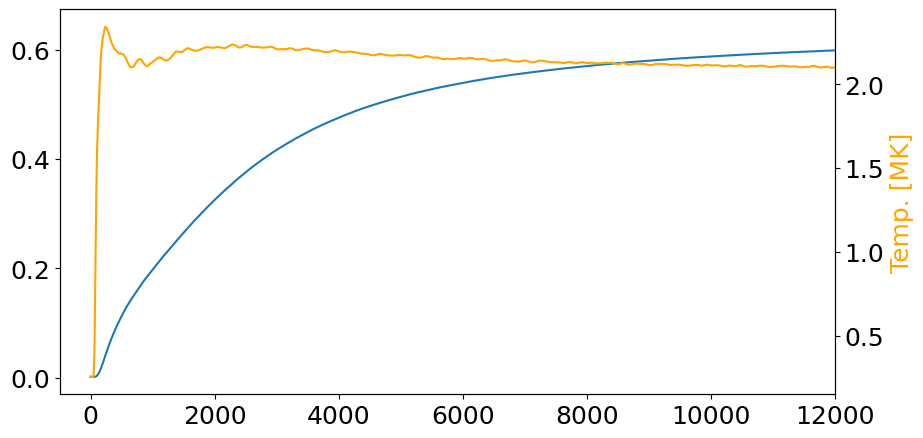

In [24]:
loop_str = loopfile.split('/')[-1][:-4]
result = [file for file in ebtel_results_files if loop_str in file][0]

_tmp = np.loadtxt(result)

# reshape into a 1D loop structure with units
time = _tmp[:, 0]
electron_temperature = _tmp[:, 1].astype('float32')
ion_temperature = _tmp[:, 2].astype('float32')
density = _tmp[:, 3].astype('float32')
velocity = _tmp[:, -2].astype('float32')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time,density/1e9)
ax.set_xlim(-500,12000)

ax1 = ax.twinx()
ax1.plot(time,electron_temperature/1e6,color='orange')
ax1.set_ylabel(r'Temp. [MK]',color='orange')


(0.0, 1000.0)

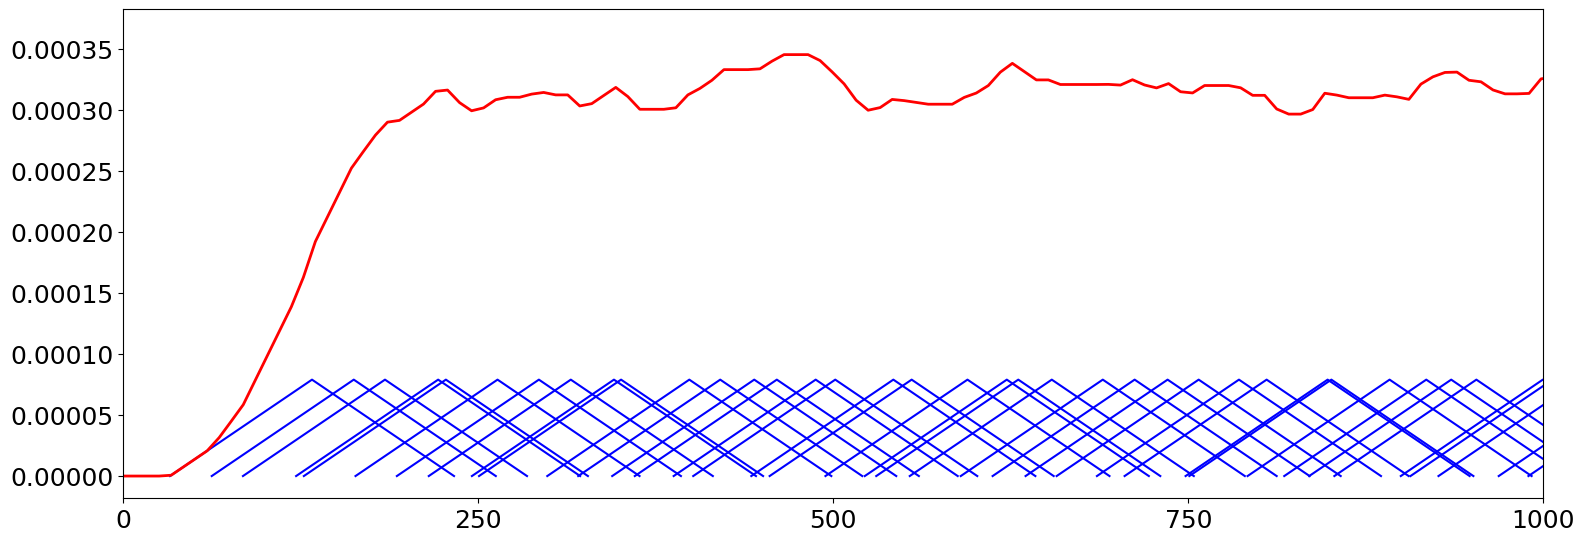

In [25]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(15, 6))

triangles = []
for e in events:

    start_time = e['time_start'].value
    rise_dur = e['rise_duration'].value
    decay_dur = e['decay_duration'].value
    total_dur = e['total_duration'].value
    peak = e['rate'].value

    rs = start_time
    re = rs + rise_dur
    de = re + decay_dur
    
    triangles.append((rs, re, de, peak))

    # Define triangle vertices: (x, y) coordinates
    x_points = [rs, re, de]  # Close the triangle by returning to start
    y_points = [0, peak, 0]   # Baseline at 0, peak at mag
    
    ax.plot(x_points, y_points, 'b-')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))

#ax.set_xlim(0.7200)

plt.tight_layout()


time_points = np.linspace(0, 84600, 10000)  # Lower resolution for speed
total_signal = np.zeros_like(time_points)

for t_idx, t in enumerate(time_points):
    for rs, re, de, peak in triangles:
        if rs <= t <= de:
            if rs <= t <= re:  
                value = peak * (t - rs) / (re - rs)
            else:  
                value = peak * (de - t) / (de - re)
            total_signal[t_idx] += value

plt.plot(time_points, total_signal, 'r-', linewidth=2)

ax.set_xlim(0,1000)



hydrad config:

base_path = os.getcwd()
path.append(os.path.join(base_path, 'modules'))

# clean HYDRAD installation
hydrad_clean = os.path.join(tmpdir, 'hydrad-clean')
if not os.path.exists(hydrad_clean):
    get_clean_hydrad(hydrad_clean, from_github=True)

ebtel_loopfile = 'ebtel_runs/heat_config_runs_h140_g0.0/hydro_config/loop000456.xml'

config_data = parse_xml_config(ebtel_loopfile)

In [26]:
loop_length = (config_data['loop_length']*u.cm).to(u.Mm)

location = 0.5
scale_height = 0.1

events = get_events(config_data['heating'],loop_length,location,scale_height)
#e2 = events[0:300]
#ttot = (e2[-1]['time_start']+e2[-1]['total_duration']).value
#ttot = config_data['total_time']


heat = events[0]
#ttot= 3600*2 #  3600
ttot = 500

#heat['rise_duration']*=1 # 200 s
heat['total_duration'] = ttot*u.s 

In [27]:
#bgrd = {'use_initial_conditions':False, 'location':0.5*ll*u.cm, 'scale_height': 1e300*u.cm, 'rate':bhrate*u.erg/u.s/u.cm**3}
bgrd = {'use_initial_conditions':True}

# configuration
config = get_defaults()
config['general']['total_time'] = ttot * u.s
config['general']['output_interval'] = 25 * u.s
config['general']['loop_length'] = loop_length
config['general']['footpoint_height'] = 3 * u.Mm

config['heating']['background'] = bgrd

config['heating']['events'] = [heat]
#config['heating']['events'] = [heat1,heat2]

#config['initial_conditions']['footpoint_temperature'] = 10000*u.K
#config['initial_conditions']['footpoint_density'] = 0.5e9*u.cm**(-3)

config['initial_conditions']['footpoint_temperature'] = 19000*u.K
config['initial_conditions']['footpoint_density'] = 0.5e9*u.cm**(-3)

config['grid']['initial_refinement_level'] = 6
config['grid']['maximum_refinement_level'] = 14
#config['grid']['maximum_cell_width'] = 0.2 * u.Mm
#config['grid']['minimum_cells'] = 400
config['radiation']['use_power_law_radiative_losses'] = True

trying to make the inital temperature jump a bit less intense, as the equilibrium temp seems to tend to that seen in EBTEL. (intense = 25s increase?)

In [ ]:
# configure and run simulation
c = Configure(config)
hydrad_results = os.path.join(hydrad_dir, 'steady-run-test')
c.setup_simulation(hydrad_results, hydrad_clean, overwrite=True)

2025-08-29 17:32:33 - root - INFO: creating /var/folders/_k/nh9r6m6j61g28c6cmc57r70c0000gp/T/tmpzi_et1z_/Heating_Model
2025-08-29 17:32:33 - root - INFO: creating /var/folders/_k/nh9r6m6j61g28c6cmc57r70c0000gp/T/tmpzi_et1z_/Heating_Model/config
2025-08-29 17:32:33 - root - INFO: copying ../files/hydrad_runs/hydrad-clean/Heating_Model/config/heating_model.cfg -> /var/folders/_k/nh9r6m6j61g28c6cmc57r70c0000gp/T/tmpzi_et1z_/Heating_Model/config
2025-08-29 17:32:33 - root - INFO: copying ../files/hydrad_runs/hydrad-clean/Heating_Model/config/beam_heating_model.cfg -> /var/folders/_k/nh9r6m6j61g28c6cmc57r70c0000gp/T/tmpzi_et1z_/Heating_Model/config
2025-08-29 17:32:33 - root - INFO: creating /var/folders/_k/nh9r6m6j61g28c6cmc57r70c0000gp/T/tmpzi_et1z_/Heating_Model/source
2025-08-29 17:32:33 - root - INFO: copying ../files/hydrad_runs/hydrad-clean/Heating_Model/source/config.h -> /var/folders/_k/nh9r6m6j61g28c6cmc57r70c0000gp/T/tmpzi_et1z_/Heating_Model/source
2025-08-29 17:32:33 - root - I

In [ ]:
c.equilibrium_heating_rate

In [ ]:
electron_temperature[0]/1e6,density[0]/1e9

In [ ]:
#run_shell_command(os.path.join(hydrad_results, 'HYDRAD.exe'))